In [3]:
# 1. Imports & Setup (Same as before)
# -------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import os


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [5]:
TRAIN_PATH = "/content/engtrain.csv"
VAL_PATH   = "/content/engdev.csv"
TEST_PATH  = "/content/engtest.csv"

train_df = pd.read_csv(TRAIN_PATH)
val_df   = pd.read_csv(VAL_PATH)
test_df  = pd.read_csv(TEST_PATH)


In [6]:
# Instead of a single LABEL_VAR, define multiple label columns:
LABEL_COLS = ["anger", "fear", "joy", "sadness", "surprise"]
TEXT_VAR   = "text"

In [7]:
# 3. Load Tokenizer & Model for Embedding Extraction
# -------------------------------------------------------
model_name = "j-hartmann/emotion-english-distilroberta-base"
text_tokenizer = AutoTokenizer.from_pretrained(model_name)
text_model = AutoModel.from_pretrained(model_name).to(device)

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

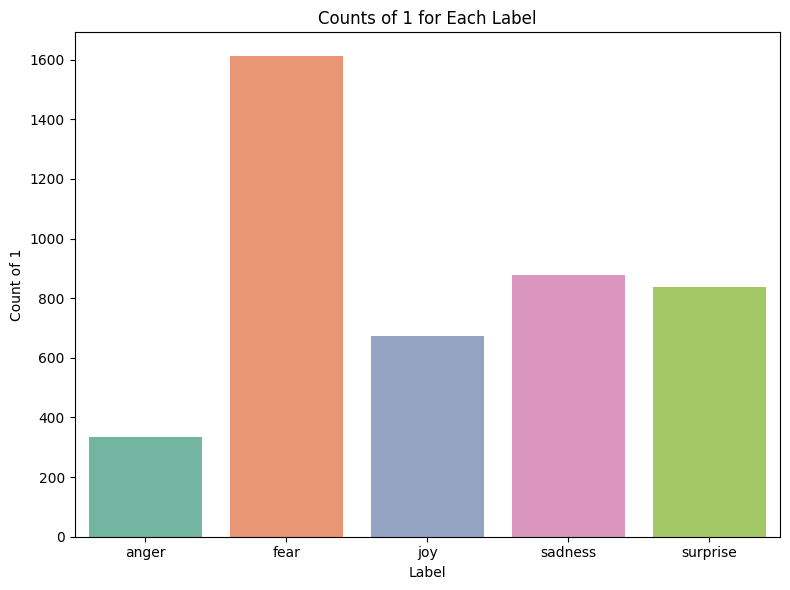

In [8]:
# Collect the counts of "1" for each label
counts_ones = []
for label in LABEL_COLS:
    # Count how many rows in train_df have this label = 1
    num_ones = (train_df[label] == 1).sum()
    counts_ones.append((label, num_ones))

# Build a DataFrame for plotting
counts_df = pd.DataFrame(counts_ones, columns=["label", "count_of_1"])

plt.figure(figsize=(8, 6))
sns.barplot(
    x="label",
    y="count_of_1",
    data=counts_df,
    palette="Set2"
)
plt.title("Counts of 1 for Each Label")
plt.xlabel("Label")
plt.ylabel("Count of 1")
plt.tight_layout()
plt.show()

In [9]:
# 4. Extract Text Embeddings (Same logic, but shorten max_length if needed)
# -------------------------------------------------------
def extract_text_embeddings(df, save_path, model, tokenizer):
    if os.path.exists(save_path):
        print(f"Embeddings already exist at {save_path}")
        return torch.load(save_path)

    embeddings = {}
    model.eval()
    with torch.no_grad():
        for idx, row in tqdm(df.iterrows(), desc="Extracting text embeddings", total=len(df)):
            text_sample = row[TEXT_VAR]
            text_sample = text_sample if isinstance(text_sample, str) else ""

            inputs = tokenizer(
                text_sample,
                padding="max_length",
                truncation=True,
                max_length=128,
                return_tensors="pt"
            ).to(device)

            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings[idx] = cls_embedding.cpu()

    torch.save(embeddings, save_path)
    return embeddings

train_text_embeddings = extract_text_embeddings(train_df, "train_text_embeddings.pt", text_model, text_tokenizer)
val_text_embeddings   = extract_text_embeddings(val_df,   "val_text_embeddings.pt",   text_model, text_tokenizer)
test_text_embeddings  = extract_text_embeddings(test_df,  "test_text_embeddings.pt",  text_model, text_tokenizer)


Extracting text embeddings: 100%|██████████| 2767/2767 [00:14<00:00, 187.76it/s]


In [10]:
# 5. Prepare Embeddings (CHANGED for Multi‐Label)
# -------------------------------------------------------
def prepare_text_embeddings(text_embeddings, df, label_cols=None, has_labels=True):
    """
    For each row in df, gather the text embedding and (optionally) the labels.
    label_cols: list of columns for multi-label (e.g. ["anger", "fear", "joy", ...])
    """
    combined_embeddings = []
    labels = []

    for idx, row in df.iterrows():
        if idx not in text_embeddings:
            continue
        # Get the [CLS] embedding
        text_embedding = text_embeddings[idx].squeeze()  # shape: (768,)
        combined_embeddings.append(text_embedding)

        if has_labels and label_cols is not None:
            # Collect all label columns as a float vector
            label_vector = row[label_cols].values.astype(float)  # shape: (5,)
            labels.append(label_vector)

    # Convert to Tensors
    if has_labels and label_cols is not None:
        X = torch.stack(combined_embeddings)
        Y = torch.tensor(labels, dtype=torch.float)  # multi-label => float
        return X, Y
    else:
        return torch.stack(combined_embeddings)

X_train, y_train = prepare_text_embeddings(train_text_embeddings, train_df, LABEL_COLS, has_labels=True)
X_val,   y_val   = prepare_text_embeddings(val_text_embeddings,   val_df,   LABEL_COLS, has_labels=True)
X_test           = prepare_text_embeddings(test_text_embeddings,  test_df,  LABEL_COLS, has_labels=False)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
print("X_test: ", X_test.shape)


X_train: torch.Size([2768, 768]) y_train: torch.Size([2768, 5])
X_val:   torch.Size([116, 768]) y_val:   torch.Size([116, 5])
X_test:  torch.Size([2767, 768])


In [11]:

def balance_multilabel_data(X, Y):
    """
    Oversample minority label-combinations in a multi-label setting.
    1. Convert each row's label vector (like [1,0,1,0,0]) into a tuple (1.0,0.0,1.0,0.0,0.0).
    2. Count how many rows share that exact tuple (i.e., label combination).
    3. Duplicate those rows until they match the frequency of the most common combination.

    NOTE: This lumps each distinct 5-label pattern as one "class."
    If every row has a unique pattern, this won't help much.
    """
    from collections import Counter

    # Convert each label row to a tuple
    label_tuples = [tuple(row.tolist()) for row in Y]
    class_counts = Counter(label_tuples)
    max_count = max(class_counts.values())

    # We'll store duplicates in lists, then convert to tensors
    balanced_embeddings = []
    balanced_labels = []

    for i, label_tuple in enumerate(label_tuples):
        balanced_embeddings.append(X[i])
        balanced_labels.append(label_tuple)

        current_count = class_counts[label_tuple]
        # e.g., duplicates_needed = how many times to replicate?
        duplicates_needed = int((max_count - current_count) / current_count)

        for _ in range(duplicates_needed):
            balanced_embeddings.append(X[i])
            balanced_labels.append(label_tuple)

    balanced_embeddings = torch.stack(balanced_embeddings)
    balanced_labels = torch.tensor(balanced_labels, dtype=torch.float)
    print(f"Original dataset size: {X.shape[0]}")
    print(f"Balanced dataset size: {balanced_embeddings.shape[0]}")
    return balanced_embeddings, balanced_labels

# Call our new multi-label balancing function
X_train, y_train = balance_multilabel_data(X_train, y_train)


Original dataset size: 2768
Balanced dataset size: 11158


In [12]:
# 6. Define Multi‐Label MLP Model (CHANGED)
# -------------------------------------------------------
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.5):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_p)
        self.fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.dropout2 = nn.Dropout(p=dropout_p)
        self.fc3 = nn.Linear(hidden_dim[1], output_dim)
        # For multi‐label, we *do not* apply softmax, we will use BCEWithLogitsLoss

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)            # shape: (batch_size, 5)
        # No softmax here for multi‐label. Return raw logits for BCEWithLogitsLoss
        return x


In [13]:
# Model & Hyperparams
input_dim    = X_train.shape[1]        # e.g. 768
hidden_dim   = [786, 512]             # can be tuned
output_dim   = len(LABEL_COLS)        # 5 for multi‐label
dropout_p    = 0.3
num_epochs   = 5
batch_size   = 16
learning_rate = 1e-4

model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)

In [14]:
# 7. CHANGED: Use BCEWithLogitsLoss (for multi‐label)
# -------------------------------------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# 8. Dataloaders
# -------------------------------------------------------
train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)
test_dataset  = TensorDataset(X_test)  # no labels for test

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size)

In [16]:
# 9. Metrics for Multi‐Label (CHANGED)
# -------------------------------------------------------
def calculate_metrics(preds, labels):
    """
    preds, labels are lists (or arrays) of shape (N, 5).
    We'll do an example with macro avg for PRF.
    """
    preds = np.array(preds)
    labels = np.array(labels)

    # Example: For each label, threshold at 0.5
    # (We already do that during loop, but let's be explicit.)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro', zero_division=0
    )
    # Multi‐label “accuracy” can be ambiguous.
    # Some do “exact match ratio”, etc. We'll do a simple overall average:
    accuracy = (preds == labels).mean()

    return accuracy, precision, recall, f1

In [17]:
# 10. Train and Validate (CHANGES in Predictions)
# -------------------------------------------------------
def train_and_save_best_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, save_dir):
    best_f1 = -float('inf')
    best_model_path = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_train_preds, all_train_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)  # shape: (batch_size, 5)
            # For BCEWithLogitsLoss, labels should be float
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Convert logits -> probabilities -> binary predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_train_preds.extend(preds.cpu().tolist())
            all_train_labels.extend(labels.cpu().tolist())

        # Training metrics
        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(all_train_preds, all_train_labels)

        # Validation
        model.eval()
        val_loss = 0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)  # shape: (batch_size, 5)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).float()
                all_val_preds.extend(preds.cpu().tolist())
                all_val_labels.extend(labels.cpu().tolist())

        val_accuracy, val_precision, val_recall, val_f1 = calculate_metrics(all_val_preds, all_val_labels)

        print(
            f"Epoch {epoch+1}/{num_epochs} "
            f"Train Loss: {train_loss/len(train_loader):.4f}, "
            f"Train Acc: {train_accuracy:.4f}, F1: {train_f1:.4f} | "
            f"Val Loss: {val_loss/len(val_loader):.4f}, "
            f"Val Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}"
        )

        # Save best model by val_f1
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_path = os.path.join(save_dir, f"best_model_epoch_{epoch+1}_f1_{val_f1:.4f}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with F1: {val_f1:.4f} at epoch {epoch+1}")

    return best_model_path

save_dir = "./models"
os.makedirs(save_dir, exist_ok=True)

best_model_path = train_and_save_best_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, save_dir
)

print(f"Best model saved at: {best_model_path}")

Epoch 1/5 Train Loss: 0.4205, Train Acc: 0.8085, F1: 0.8004 | Val Loss: 0.4777, Val Acc: 0.7914, F1: 0.6608
Best model saved with F1: 0.6608 at epoch 1
Epoch 2/5 Train Loss: 0.2749, Train Acc: 0.8876, F1: 0.8836 | Val Loss: 0.4863, Val Acc: 0.7879, F1: 0.6409
Epoch 3/5 Train Loss: 0.2128, Train Acc: 0.9162, F1: 0.9135 | Val Loss: 0.5363, Val Acc: 0.7603, F1: 0.6076
Epoch 4/5 Train Loss: 0.1729, Train Acc: 0.9343, F1: 0.9325 | Val Loss: 0.5272, Val Acc: 0.7914, F1: 0.6325
Epoch 5/5 Train Loss: 0.1440, Train Acc: 0.9471, F1: 0.9459 | Val Loss: 0.5977, Val Acc: 0.7724, F1: 0.6160
Best model saved at: ./models/best_model_epoch_1_f1_0.6608.pth


In [18]:
# 11. Test Predictions (CHANGES for Multi‐Label)
# -------------------------------------------------------
def predict_and_generate_submission(test_loader, best_model_path, submission_file_path):
    # Reload a fresh model
    inference_model = MLPModel(input_dim, hidden_dim, output_dim, dropout_p).to(device)
    inference_model.load_state_dict(torch.load(best_model_path))
    inference_model.eval()

    # We'll store multi‐label predictions as 0/1 for each label
    test_predictions = []
    with torch.no_grad():
        for (inputs,) in test_loader:  # Each batch is a tuple containing only X
            inputs = inputs.to(device)
            outputs = inference_model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).int()  # shape: (batch_size, 5)
            test_predictions.append(preds.cpu())

    test_predictions = torch.cat(test_predictions, dim=0).numpy()  # shape: (num_samples, 5)

    # Build submission DataFrame
    submission_df = pd.DataFrame({
        "id": test_df["id"],  # or whatever your ID is
        "anger_pred":    test_predictions[:, 0],
        "fear_pred":     test_predictions[:, 1],
        "joy_pred":      test_predictions[:, 2],
        "sadness_pred": test_predictions[:, 3],
        "surprise_pred":test_predictions[:, 4]
    })

    submission_df.to_csv(submission_file_path, index=False)
    print(f"Submission file saved to {submission_file_path}")
    return submission_df

submission_file_path = "submission.csv"
submission_df = predict_and_generate_submission(test_loader, best_model_path, submission_file_path)
submission_df.head()

Submission file saved to submission.csv


,id,anger_pred,fear_pred,joy_pred,sadness_pred,surprise_pred
0,eng_test_track_a_00001,0,1,0,1,0
1,eng_test_track_a_00002,0,1,0,1,0
2,eng_test_track_a_00003,1,1,0,0,1
3,eng_test_track_a_00004,0,1,0,0,0
4,eng_test_track_a_00005,0,1,1,1,0


Confusion matrices saved to: /content/confusion_matrices.png


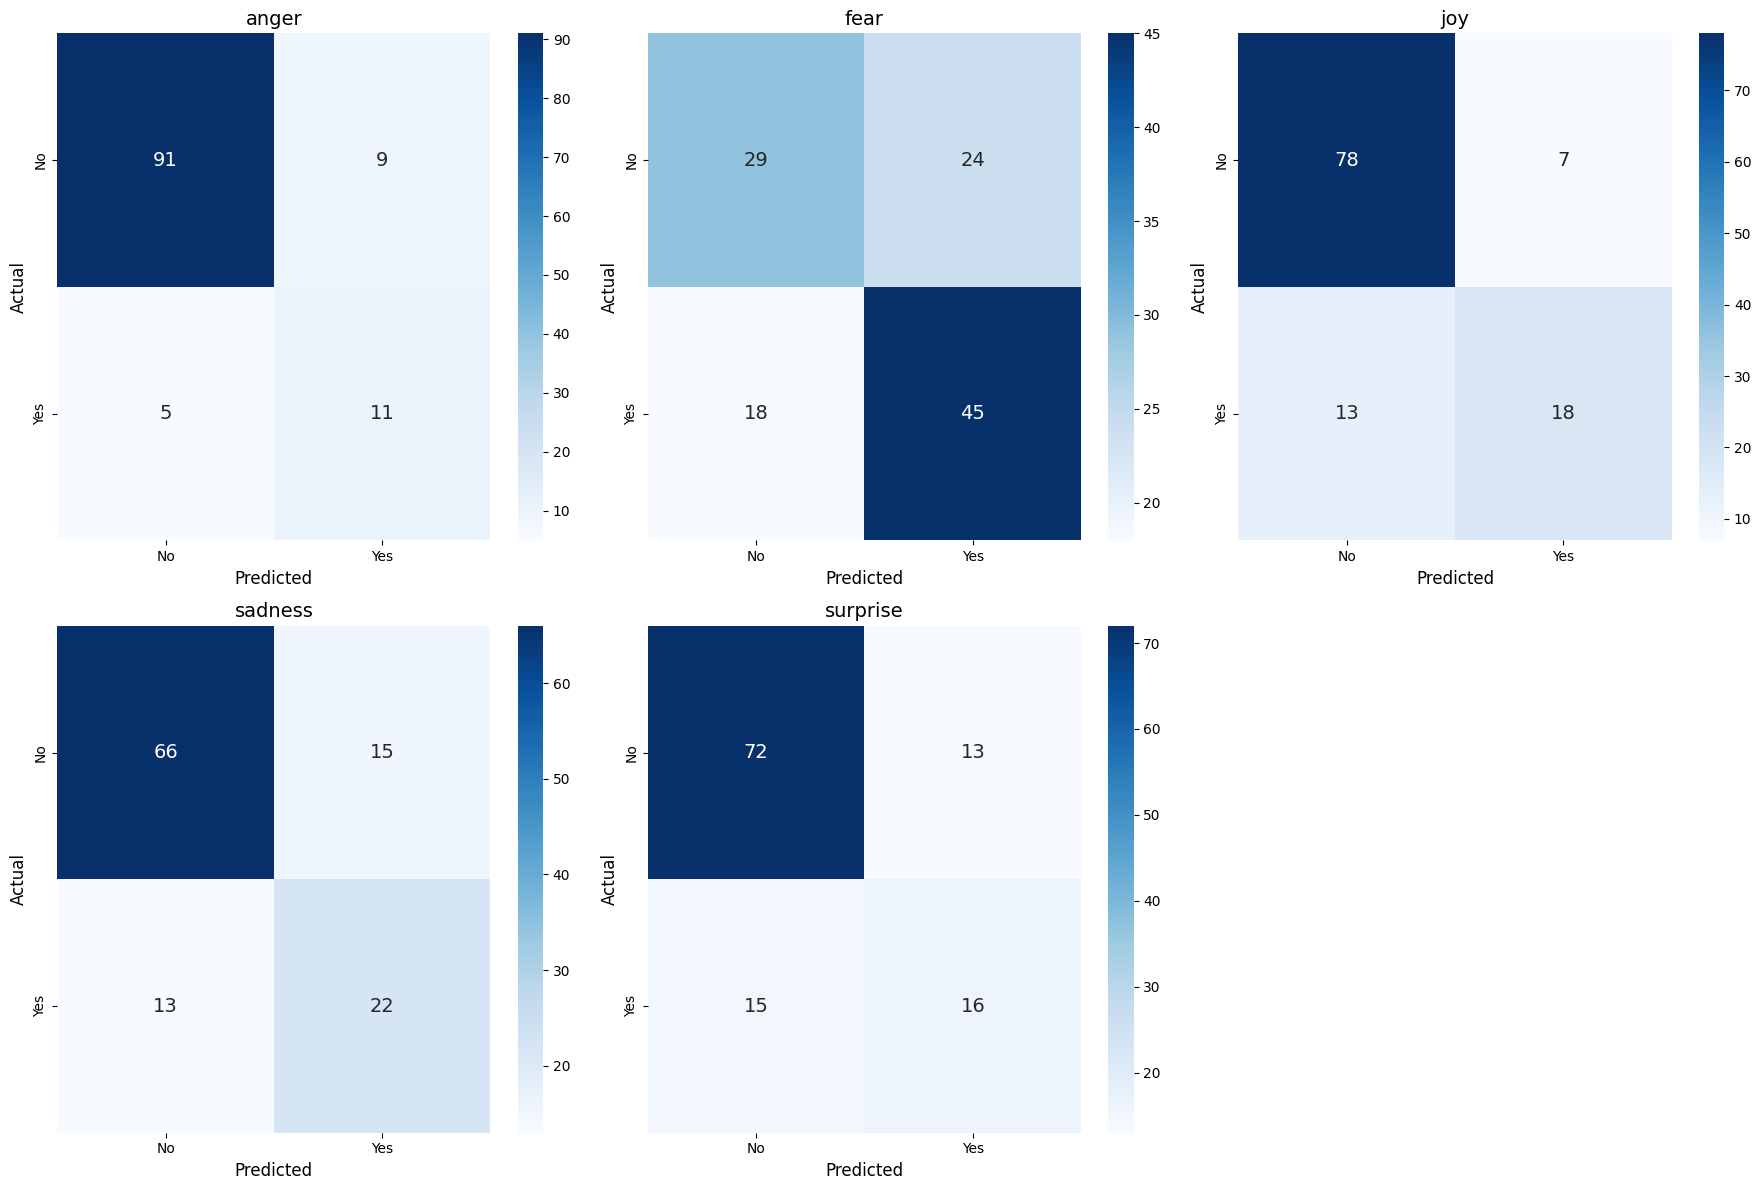

In [19]:
from sklearn.metrics import confusion_matrix  # Add this to your existing sklearn imports

def plot_all_confusion_matrices(model, data_loader, label_cols, save_path=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Get binary predictions
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    num_labels = len(label_cols)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2x3 grid for 5 labels + 1 empty
    axes = axes.ravel()

    for i in range(num_labels):
        cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
        ax = axes[i]
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No", "Yes"], yticklabels=["No", "Yes"], ax=ax,
            annot_kws={"size": 14}
        )
        ax.set_xlabel("Predicted", fontsize=12)
        ax.set_ylabel("Actual", fontsize=12)
        ax.set_title(f"{label_cols[i]}", fontsize=14)
        ax.tick_params(axis='both', labelsize=10)

    # Hide the empty subplot
    if num_labels < len(axes):
        for j in range(num_labels, len(axes)):
            fig.delaxes(axes[j])

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"Confusion matrices saved to: {save_path}")


    plt.tight_layout()
    plt.show()

# Call the function after training
plot_all_confusion_matrices(model, val_loader, LABEL_COLS,save_path="/content/confusion_matrices.png")

In [21]:
def display_predictions(model, data_loader, df, num_samples=5):
    model.eval()
    all_preds, all_labels, texts = [], [], []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            #batch_size = outputs.size(0) #Unnecessary
            #outputs = outputs.view(batch_size, 6, 4) # Remove this line
            preds = (torch.sigmoid(outputs) > 0.5).int() #Get Multi-label predictions

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    # Add corresponding text data for reference
    texts = df[TEXT_VAR].tolist()

    correct_samples = []
    incorrect_samples = []

    for i in range(len(all_preds)):
        if np.array_equal(all_preds[i], all_labels[i]):  # Fully correct
            correct_samples.append((texts[i], all_preds[i], all_labels[i]))
        else:  # Incorrect prediction
            incorrect_samples.append((texts[i], all_preds[i], all_labels[i]))

    print("\n✅ Correct Predictions:")
    for i, (text, pred, true) in enumerate(correct_samples[:num_samples]):
        print(f"\n🔹 Sample {i+1}:")
        print(f"Text: {text}")
        print(f"Predicted: {pred} | Actual: {true}")

    print("\n❌ Incorrect Predictions:")
    for i, (text, pred, true) in enumerate(incorrect_samples[:num_samples]):
        print(f"\n🔹 Sample {i+1}:")
        print(f"Text: {text}")
        print(f"Predicted: {pred} | Actual: {true}")

# Call the function
display_predictions(model, val_loader, val_df, num_samples=5)


✅ Correct Predictions:

🔹 Sample 1:
Text: We're still together.
Predicted: [0 0 1 0 0] | Actual: [0. 0. 1. 0. 0.]

🔹 Sample 2:
Text: After that first big experience I started doing some research because I was so confused.
Predicted: [0 1 0 0 1] | Actual: [0. 1. 0. 0. 1.]

🔹 Sample 3:
Text: I have a floor shift in the morning, hopefully without my nose being stuffy.
Predicted: [0 1 0 0 0] | Actual: [0. 1. 0. 0. 0.]

🔹 Sample 4:
Text: can't wait to be in another wedding!
Predicted: [0 0 1 0 0] | Actual: [0. 0. 1. 0. 0.]

🔹 Sample 5:
Text: I would go over to his house where his Grandmother and mom and dad lived to play SSX Tricky and eat Pokemon fruit rollups.
Predicted: [0 0 1 0 0] | Actual: [0. 0. 1. 0. 0.]

❌ Incorrect Predictions:

🔹 Sample 1:
Text: Older sister (23 at the time) is a Scumbag Stacy.
Predicted: [0 0 1 0 0] | Actual: [1. 0. 0. 0. 0.]

🔹 Sample 2:
Text: And I laughed like this: garhahagar, because my mouth was full of cotton and shit to bite down on and sharp objects and